colab link: https://colab.research.google.com/drive/1Ai2V1c3F8PQHQj3w70_r1WupBuevKQ70?usp=sharing

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch
from transformers import AutoModelForSequenceClassification, AdamW

from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
np.random.seed(123)
from transformers import BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## Load data

data set: https://huggingface.co/datasets/dair-ai/emotion

here we use the command line tool to preprocess the .jsonl dataset first:

jq -r '. | [.text, .label | tostring] | @csv' train.jsonl | awk 'BEGIN{print "text,label"}{print}' > train.csv

jq -r '. | [.text, .label | tostring] | @csv' test.jsonl | awk 'BEGIN{print "text,label"}{print}' > test.csv

In [ ]:
# Load data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# Display
print("Train Data:")
print(train_data.head())
print(train_data.shape)
print("\nTest Data:")
print(test_data.head())
print(test_data.shape)

Train Data:
                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3
(16000, 2)

Test Data:
                                                text  label
0  im feeling rather rotten so im not very ambiti...      0
1          im updating my blog because i feel shitty      0
2  i never make her separate from me because i do...      0
3  i left with my bouquet of red and yellow tulip...      1
4    i was feeling a little vain when i did this one      0
(2000, 2)


## Some visualization

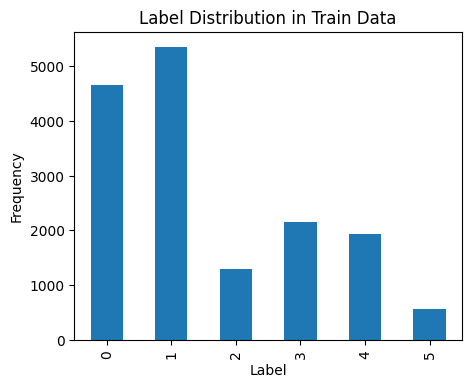

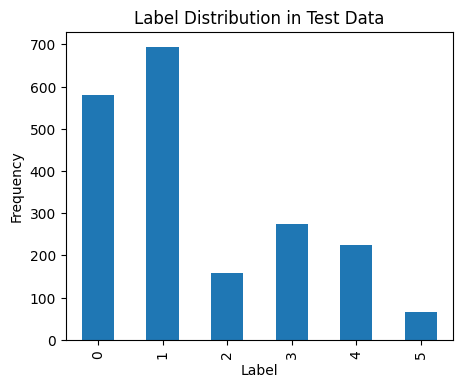

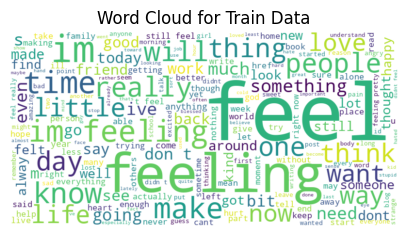

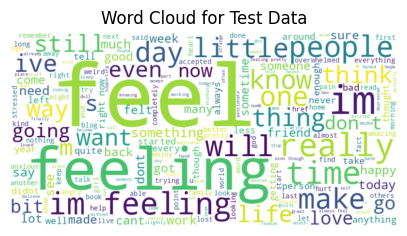

In [ ]:
# Function to plot histograms for label distribution
def plot_label_distribution(data, title):
    plt.figure(figsize=(5, 4))
    data['label'].value_counts().sort_index().plot(kind='bar')
    plt.title(f'Label Distribution in {title}')
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.show()

# Function to plot a word cloud
def plot_word_cloud(data, title):
    text = ' '.join(data['text'].astype(str).tolist())
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)
    plt.figure(figsize=(5, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {title}')
    plt.axis('off')
    plt.show()

# Plot label distributions
plot_label_distribution(train_data, "Train Data")
plot_label_distribution(test_data, "Test Data")

# Plot word clouds
plot_word_cloud(train_data, "Train Data")
plot_word_cloud(test_data, "Test Data")

## Vectorize text


In [ ]:
# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit on both datasets to ensure vocabulary is consistent across both datasets
combined_text = pd.concat([train_data['text'], test_data['text']], axis=0)
vectorizer.fit(combined_text)

# Transform the training and testing data separately
X_train = vectorizer.transform(train_data['text'])
X_test = vectorizer.transform(test_data['text'])

# Convert to DataFrame
feature_names = vectorizer.get_feature_names_out()
train_df = pd.DataFrame(X_train.toarray(), columns=feature_names)
test_df = pd.DataFrame(X_test.toarray(), columns=feature_names)

# Display the transformed data
print("\nTransformed Train text Data:")
# print(train_df.head())
print(train_df.shape)
print("\nTransformed Test text Data:")
# print(test_df.head())
print(test_df.shape)


Transformed Train text Data:
(16000, 16158)

Transformed Test text Data:
(2000, 16158)


## convert into ndarray


In [ ]:
# Extract labels and convert to ndarray
y_train = train_data['label'].to_numpy().reshape(-1, 1)
y_test = test_data['label'].to_numpy().reshape(-1, 1)

# Convert feature DataFrame to ndarray
x_train = train_df.to_numpy()
x_test = test_df.to_numpy()

# Print shapes for verification
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

y_train shape: (16000, 1)
y_test shape: (2000, 1)
x_train shape: (16000, 16158)
x_test shape: (2000, 16158)


## Naive Bayes Model


In [ ]:
class NaiveBayes:
    def __init__(self):
        self.class_log_prior_ = None
        self.feature_log_prob_ = None
        self.classes_ = None

    def fit(self, x, y):
        # Calculate the prior probability of each class and take the logarithm
        self.classes_, y_counts = np.unique(y, return_counts=True)
        self.class_log_prior_ = np.log(y_counts / y_counts.sum())

        # Calculate the conditional probability P(feature|class)
        self.feature_log_prob_ = []
        for c in self.classes_:
            # Select samples for each class
            x_c = x[y == c]
            # Calculate the probability of each feature and take the logarithm
            class_feature_prob = (x_c.sum(axis=0) + 1) / (x_c.sum() + x_c.shape[1])
            self.feature_log_prob_.append(np.log(class_feature_prob))

        self.feature_log_prob_ = np.array(self.feature_log_prob_)

    def predict(self, xt):
        # Calculate the probability for each sample belonging to each class
        log_probs = xt @ self.feature_log_prob_.T + self.class_log_prior_
        # Choose the class with the highest probability
        return self.classes_[np.argmax(log_probs, axis=1)]

    def eval(self, y_true, y_pred):
        # Calculate accuracy
        return (y_true == y_pred).mean()

### Use Naive Bayes to make prediction


In [ ]:
# Instantiate the Naive Bayes classifier
nb = NaiveBayes()

# Train the model
nb.fit(x_train, y_train.flatten())  # Assuming y_train is a two-dimensional array

# Predict on the test set
y_pred = nb.predict(x_test)

# Calculate accuracy
accuracy = nb.eval(y_test.flatten(), y_pred)
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 76.9%


### calculate different metrics of Naive Bayes model

In [ ]:
def calculate_metrics(y_true, y_pred, num_classes):
    # Initialize metrics
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)

    # Calculate metrics for each class
    for cls in range(num_classes):
        true_positive = np.sum((y_pred == cls) & (y_true == cls))
        false_positive = np.sum((y_pred == cls) & (y_true != cls))
        false_negative = np.sum((y_pred != cls) & (y_true == cls))
        true_negative = np.sum((y_pred != cls) & (y_true != cls))

        precision[cls] = true_positive / (true_positive + false_positive) if true_positive + false_positive > 0 else 0
        recall[cls] = true_positive / (true_positive + false_negative) if true_positive + false_negative > 0 else 0
        f1[cls] = 2 * (precision[cls] * recall[cls]) / (precision[cls] + recall[cls]) if precision[cls] + recall[cls] > 0 else 0

    # Calculate the macro-average of the metrics
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)

    # Calculate accuracy
    accuracy = np.mean(y_true == y_pred)

    return accuracy, macro_precision, macro_recall, macro_f1

# Use the calculate_metrics function
num_classes = 6
accuracy, precision, recall, f1 = calculate_metrics(y_test.flatten(), y_pred, num_classes)


# Create a DataFrame to display the results
results_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Value": [accuracy, precision, recall, f1]
})

# Print the DataFrame
results_df

,Metric,Value
0,Accuracy,0.769000
1,Precision,0.672197
2,Recall,0.548084
3,F1 Score,0.570575


## Bert Model

Pre-trained Bert model: https://huggingface.co/bhadresh-savani/bert-base-uncased-emotion

### Preprocess data for bert


In [ ]:
# 1. Load pre-trained model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# 2. Tokenizer
def tokenize_texts(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# 3. Apply tokenization
# train_encodings = tokenize_texts(train_data['text'].tolist())
# test_encodings = tokenize_texts(test_data['text'].tolist())
train_encodings = tokenizer(train_data['text'].tolist(), padding='max_length', truncation=True, max_length=87, return_tensors="pt")
test_encodings = tokenizer(test_data['text'].tolist(), padding='max_length', truncation=True, max_length=87, return_tensors="pt")

# 4. Convert tokenized data to tensors
x_train = train_encodings['input_ids']
x_test = test_encodings['input_ids']


attention_masks_train = train_encodings['attention_mask']
attention_masks_test = test_encodings['attention_mask']


y_train_tensor = torch.tensor(y_train)
y_test_tensor = torch.tensor(y_test)

# Print the shape of all tensors
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

x_train shape: torch.Size([16000, 87])
x_test shape: torch.Size([2000, 87])
y_train_tensor shape: torch.Size([16000, 1])
y_test_tensor shape: torch.Size([2000, 1])


### Using pre-trained BERT model for prediction without tunning

In [ ]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load a pretrained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)
model.to(device)
model.eval()

# Define test data loader
test_dataset = TensorDataset(x_test, y_test_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

# make predictions
predictions, true_labels = [], []

for batch in test_dataloader:
    b_input_ids, b_labels = [t.to(device) for t in batch]

    with torch.no_grad():
        outputs = model(b_input_ids)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

# Calculate accuracy
predicted_labels_flat = np.concatenate([np.argmax(x, axis=1) for x in predictions], axis=0)
true_labels_flat = np.concatenate(true_labels, axis=0)

accuracy = accuracy_score(true_labels_flat, predicted_labels_flat)
print("Prediction Accuracy: {:.2f}%".format(accuracy * 100))

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prediction Accuracy: 29.05%


### Using pre-trained BERT model for prediction and fine-tuning all layers (weights)

In [ ]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load a pretrained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)
model.to(device)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Define data loader
train_dataset = TensorDataset(x_train, y_train_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=32)

# trainning epochs
epochs = 4

# Total training steps
total_steps = len(train_dataloader) * epochs

# Define learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

# Fine-tuning the model
for epoch in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("Average training loss: {0:.2f}".format(avg_train_loss))

# Evaluation model
test_dataset = TensorDataset(x_test, y_test_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

model.eval()
predictions , true_labels = [], []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

# Calculate accuracy
predicted_labels_flat = np.concatenate([np.argmax(x, axis=1) for x in predictions], axis=0)
true_labels_flat = np.concatenate(true_labels, axis=0)

accuracy = accuracy_score(true_labels_flat, predicted_labels_flat)
print("Prediction Accuracy: {:.2f}%".format(accuracy * 100))

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


======== Epoch 1 / 4 ========
Average training loss: 0.79
======== Epoch 2 / 4 ========
Average training loss: 0.18
======== Epoch 3 / 4 ========
Average training loss: 0.12
======== Epoch 4 / 4 ========
Average training loss: 0.09
Prediction Accuracy: 93.15%


### Using pre-trained BERT model for prediction and only fine-tuning the last classifier layer.

In [ ]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load a pretrained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)

# Freeze all layers and train only the last classifier layer
for param in model.bert.parameters():
    param.requires_grad = False

model.to(device)

# Define optimizer
optimizer = AdamW(model.classifier.parameters(), lr=2e-5)

# Define data loader
train_dataset = TensorDataset(x_train, y_train_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=32)

# trainning epochs
epochs = 4

# Total training steps
total_steps = len(train_dataloader) * epochs

# Define learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

# Fine-tuning the model
for epoch in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.classifier.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("Average training loss: {0:.2f}".format(avg_train_loss))

# Evaluation model
test_dataset = TensorDataset(x_test, y_test_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

model.eval()
predictions , true_labels = [], []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

# Calculate accuracy
predicted_labels_flat = np.concatenate([np.argmax(x, axis=1) for x in predictions], axis=0)
true_labels_flat = np.concatenate(true_labels, axis=0)

accuracy = accuracy_score(true_labels_flat, predicted_labels_flat)
print("Prediction Accuracy: {:.2f}%".format(accuracy * 100))


Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


======== Epoch 1 / 4 ========
Average training loss: 1.62
======== Epoch 2 / 4 ========
Average training loss: 1.58
======== Epoch 3 / 4 ========
Average training loss: 1.58
======== Epoch 4 / 4 ========
Average training loss: 1.58
Prediction Accuracy: 34.75%


### Using pre-trained BERT model for prediction and fine-tuning only the last 5 Transformer layers.

In [ ]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load a pretrained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)

# Freeze all but the last five Transformer layers
for name, param in model.named_parameters():
    if name.startswith("bert.encoder.layer") and int(name.split(".")[3]) < 7:
        param.requires_grad = False

model.to(device)

# Define optimizer
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)

# Define data loader
train_dataset = TensorDataset(x_train, y_train_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=32)

# trainning epochs
epochs = 4

# Total training steps
total_steps = len(train_dataloader) * epochs

# Define learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

# Fine-tuning the model
for epoch in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("Average training loss: {0:.2f}".format(avg_train_loss))

# Evaluation model
test_dataset = TensorDataset(x_test, y_test_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

model.eval()
predictions , true_labels = [], []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

# Calculate accuracy
predicted_labels_flat = np.concatenate([np.argmax(x, axis=1) for x in predictions], axis=0)
true_labels_flat = np.concatenate(true_labels, axis=0)

accuracy = accuracy_score(true_labels_flat, predicted_labels_flat)
print("Prediction Accuracy: {:.2f}%".format(accuracy * 100))


Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


======== Epoch 1 / 4 ========
Average training loss: 1.03
======== Epoch 2 / 4 ========
Average training loss: 0.39
======== Epoch 3 / 4 ========
Average training loss: 0.25
======== Epoch 4 / 4 ========
Average training loss: 0.19
Prediction Accuracy: 91.05%


## Comparison of accuracy between the Naive Bayes model and four pretrained BERT models

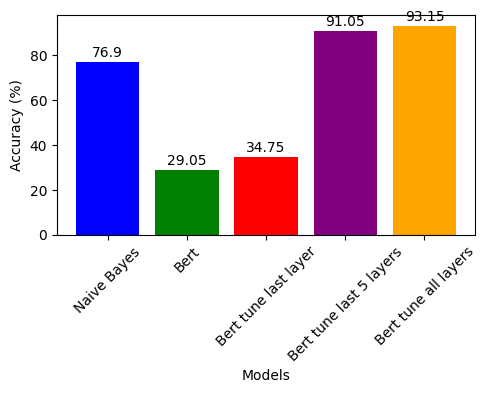

In [ ]:
# Data from the user's table
models = ['Naive Bayes', 'Bert', 'Bert tune last layer', 'Bert tune last 5 layers', 'Bert tune all layers']
accuracy = [76.9, 29.05, 34.75, 91.05, 93.15] # accuracy we get from previous result

# Creating the bar chart with rotated x-axis labels and different colors for each bar
plt.figure(figsize=(5, 4))
colors = ['blue', 'green', 'red', 'purple', 'orange']
bars = plt.bar(models, accuracy, color=colors)

# Adding the data labels on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom')

# Rotating the x-axis labels
plt.xticks(rotation=45)

# Setting the title and labels
# plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')

# Display the chart
plt.tight_layout()
plt.show()

- The accuracy of the predictions may not be high because the pre-trained model has not been tuned for my specific task. This is particularly evident when using complex models like BERT, as these models usually need to be fine-tuned with data for specific tasks to achieve optimal performance. In practical applications, we usually do additional training (i.e., fine-tuning) on similar pre-trained models to make them better adapt to our specific tasks and data.

- But pre-training is equally important. Without pre-training, even with fine-tuning, the results would be poor. Models without pre-training may struggle to understand complex language features and structures, especially with limited training data. Pre-training allows the model to have stronger adaptability and understanding in a wider range of data and tasks.

## Examine the attention matrix using all-layer fine-tuned Bert model

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load a pretrained BERT model with output_attentions set to True
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6, output_attentions=True)
model.to(device)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Define data loader for training
train_dataset = TensorDataset(x_train, y_train_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=32)

# Training epochs
epochs = 4

# Total training steps
total_steps = len(train_dataloader) * epochs

# Define learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Fine-tuning the model
for epoch in range(epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print("Average training loss: {0:.2f}".format(avg_train_loss))

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


======== Epoch 1 / 4 ========
Average training loss: 1.20
======== Epoch 2 / 4 ========
Average training loss: 0.22
======== Epoch 3 / 4 ========
Average training loss: 0.12
======== Epoch 4 / 4 ========
Average training loss: 0.10


### Draw the attention matrix for some documents (3 correct and 3 incorrect)

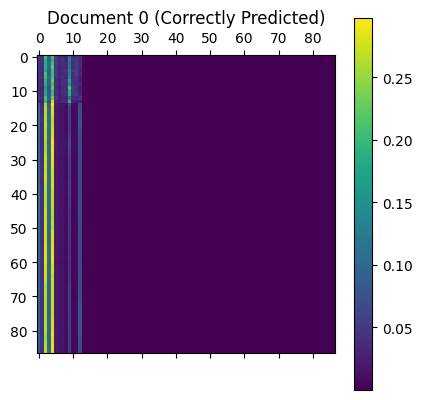

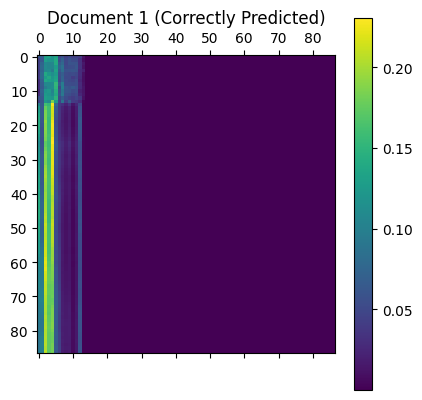

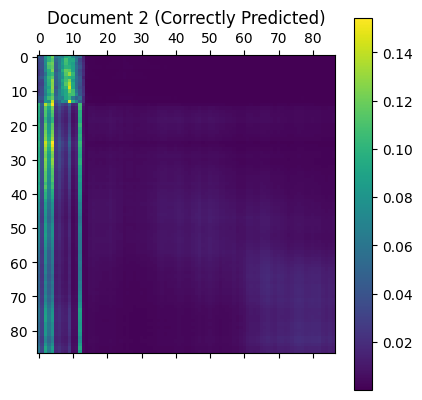

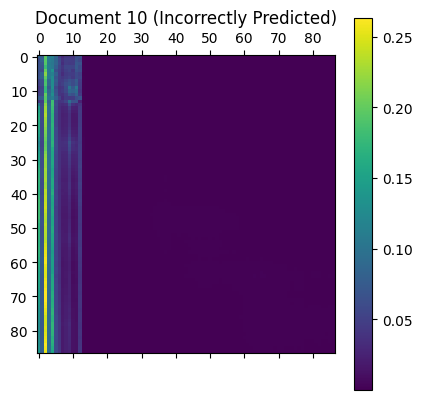

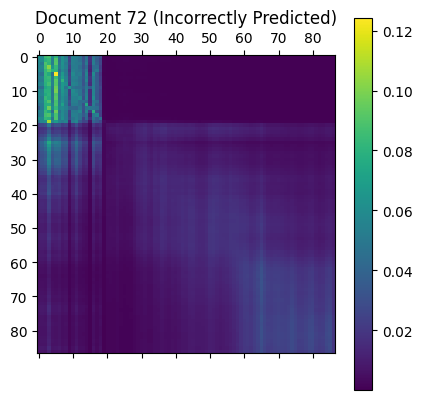

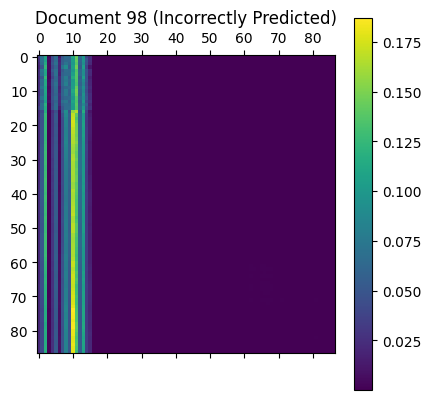

In [ ]:
# Evaluation model
test_dataset = TensorDataset(x_test, y_test_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

model.eval()
predictions, true_labels, attentions = [], [], []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids)
        logits, batch_attentions = outputs.logits, outputs.attentions

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)
    attentions.append(batch_attentions)

# Flatten the predictions and true labels
predicted_labels_flat = np.concatenate([np.argmax(x, axis=1) for x in predictions], axis=0)
true_labels_flat = np.concatenate(true_labels, axis=0)

# Choose a specific layer and head
layer = -1  # Last layer (BERT models have 12 layers)
head = 0    # First head (0 to 11)

# Initialize counters
correct_count, incorrect_count = 0, 0

# Visualize attention for specific documents
for batch_idx in range(len(attentions)):
    batch_attention = attentions[batch_idx]
    batch_size = batch_attention[layer][head].size(0)

    for within_batch_idx in range(batch_size):
        i = batch_idx * test_dataloader.batch_size + within_batch_idx
        if i >= len(predicted_labels_flat):
            break

        attention_matrix = batch_attention[layer][head][within_batch_idx].cpu().numpy()

        if true_labels_flat[i] == predicted_labels_flat[i] and correct_count < 3:
            plt.matshow(attention_matrix)
            plt.title(f"Document {i} (Correctly Predicted)")
            plt.colorbar()
            plt.show()
            correct_count += 1
        elif true_labels_flat[i] != predicted_labels_flat[i] and incorrect_count < 3:
            plt.matshow(attention_matrix)
            plt.title(f"Document {i} (Incorrectly Predicted)")
            plt.colorbar()
            plt.show()
            incorrect_count += 1

        if correct_count >= 3 and incorrect_count >= 3:
            break

    if correct_count >= 3 and incorrect_count >= 3:
        break


The heatmap shows the attention weights between tokens in a text sequence processed by the model. The x-axis and y-axis represent the sequence positions, and the color intensity reflects the attention from one token to another, with brighter colors indicating higher attention.

- A concentration of attention at the beginning of the sequence (the left side of the heatmap). This could indicate that the initial tokens are particularly important for the model's prediction for this document.

- The vertical lines suggest that specific tokens in the sequence are being attended to by many other tokens, which could signify their importance in the context of the text.

- we see that certain tokens or positions within the text receive more attention (indicated by brighter colors), it could suggests that the pre-trained model has learned to focus on the most salient parts of the text for emotion prediction.

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load a pretrained BERT model with output_attentions set to True
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=6,
    output_attentions=True,
    output_hidden_states=True  # We'll also need hidden states for layer analysis
)
model.to(device)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Define data loader for training
train_dataset = TensorDataset(x_train, y_train_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=32)

# Training epochs
epochs = 4

# Total training steps
total_steps = len(train_dataloader) * epochs

# Define learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Fine-tuning the model
for epoch in range(epochs):
    print(f'======== Epoch {epoch + 1} / {epochs} ========')
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        b_input_ids, b_labels = batch[0].to(device), batch[1].to(device)
        model.zero_grad()
        outputs = model(b_input_ids, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss:.2f}")


Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


======== Epoch 1 / 4 ========
Average training loss: 1.35
======== Epoch 2 / 4 ========
Average training loss: 0.25
======== Epoch 3 / 4 ========
Average training loss: 0.14
======== Epoch 4 / 4 ========
Average training loss: 0.10


### Draw the activation levels of the [CLS] token in different layers

In [ ]:
torch.cuda.empty_cache()

# Define data loader for evaluation
test_dataset = TensorDataset(x_test, y_test_tensor)
test_sampler = RandomSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=16)

model.eval()
predictions, true_labels = [], []
attention_weights_list, hidden_states_list = [], []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, labels=b_labels)

    logits = outputs.logits
    attention_weights = outputs.attentions
    hidden_states = outputs.hidden_states

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

    attention_weights_list.append(tuple(att.detach().cpu() for att in attention_weights))
    hidden_states_list.append(tuple(hs.detach().cpu() for hs in hidden_states))

# Flatten the predictions and true labels
predicted_labels_flat = np.concatenate(predictions, axis=0).argmax(axis=1)
true_labels_flat = np.concatenate(true_labels, axis=0)


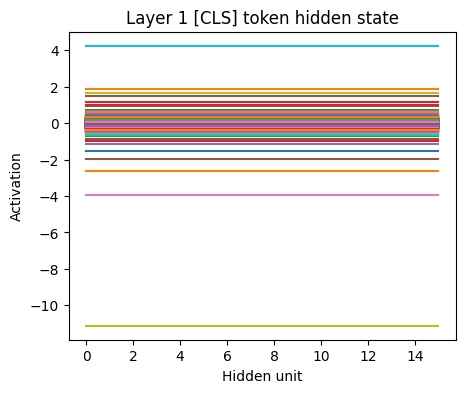

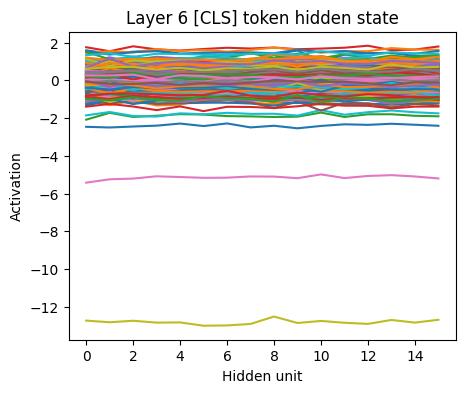

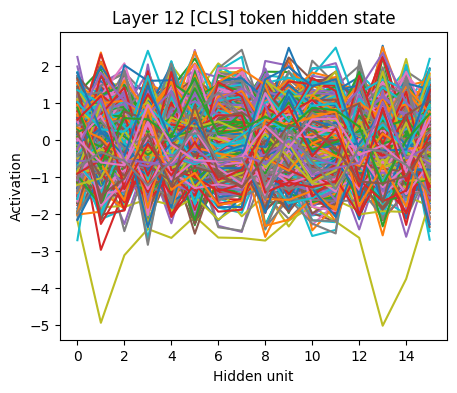

In [ ]:
# document to visualize
doc_index = 0

# Specify the layers
layers_to_visualize = [0, 5, 11]

# Plot the hidden state of the [CLS] token for specified layers
for layer_num in layers_to_visualize:
    # Extract the hidden states for the specified layer
    cls_hidden_state = hidden_states_list[doc_index][layer_num][:, 0, :].squeeze().cpu().numpy()
    # Plot
    plt.figure(figsize=(5, 4))
    plt.plot(cls_hidden_state)
    plt.title(f"Layer {layer_num + 1} [CLS] token hidden state")
    plt.xlabel("Hidden unit")
    plt.ylabel("Activation")
    plt.show()


The graphs display the activation levels of the [CLS] token's hidden state from three different layers within a BERT model. Each line in a graph represents the pattern of activation across 16 hidden units (neurons) for a single instance (input):

- Layer 1 [CLS] token hidden state: The activations are relatively flat, indicating that at this early stage, the model's representations are likely raw and less abstract. This suggests that pretraining helps the model to start forming basic representations of the input data, which are further refined in subsequent layers.

- Layer 6 [CLS] token hidden state: The plot shows more variation in activation patterns compared to Layer 1, which implies that by this middle layer, the model is beginning to develop more complex features. Pretraining has likely helped the model to learn patterns in language that are useful for interpreting emotional content, even if not directly trained on emotion-specific data.

- Layer 12 [CLS] token hidden state: There is a high degree of variability in the activations, indicating complex interactions and a sophisticated level of abstraction. This complexity is crucial for tasks like emotion prediction because the model needs to synthesize nuanced features from the input text to understand and predict emotions accurately. Pretraining on a large corpus allows BERT to capture a wide range of language nuances, which is likely beneficial for identifying subtle emotional cues in the text.

the evolution of activation patterns across layers suggests that pre-trained BERT with the ability to process and synthesize complex features from text, which is likely to be beneficial for accurately predicting emotions.